# Experiment Run

*Spatio-Directional Clustering for Soccer Actions Pattern Discovery*

Joaquin Garay

In [1]:
%load_ext autoreload
%autoreload 2

import os
from time import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="white")

import vis
import softclustering as sc
import socceraction.spadl as spadl

### Load data

In [2]:
datafolder = "data"
fifa2018h5 = os.path.join(datafolder, "spadl-fifa2018.h5")
games = pd.read_hdf(fifa2018h5, key="games")
with pd.HDFStore(fifa2018h5) as store:
    actions = []  #list of DataFrames
    for game in tqdm(games.itertuples()):
        game_action = store[f"actions/game_{game.game_id}"]
        game_action = spadl.play_left_to_right(game_action, game.home_team_id)
        game_action["is_home"] = game_action["team_id"] == game.home_team_id
        actions.append(game_action)
    actions = pd.concat(actions)
    actions.drop("original_event_id", axis=1, inplace=True)
    actions = pd.merge(actions, spadl.config.actiontypes_df(), how="left")
    actions = sc.consolidate(actions)
    actions = sc.add_noise(actions)
    actions = sc.remove_outliers(actions, True)
    actions["angle"] = np.arctan2(actions.end_y - actions.start_y, actions.end_x - actions.start_x)
    actions["cos_angle"] = np.cos(actions["angle"])
    actions["sin_angle"] = np.sin(actions["angle"])



64it [00:00, 217.25it/s]


Remove 524 out of 128484 datapoints.


## Experiment

There are 10 action types that are to be clustered by their location using Gaussian mixture distribution. Some of the actions don't have an end location, thus they are not relevant for this research because we can't compute their direction. Also the action "shot_penalty" always has the same start location, so no need to cluster them.

In [3]:
# select actions type to run location soft clustering
# shot penalty has always the same starting point
no_dir_action_types = set(actions[actions["angle"] == 0.0]["type_name"])
action_types = sorted(set(actions["type_name"]) - no_dir_action_types - {"shot_penalty"})
action_types

['clearance',
 'corner',
 'cross',
 'dribble',
 'freekick',
 'goalkick',
 'keeper_action',
 'pass',
 'shot',
 'throw_in']

### Location mixture: Number of clusters calibration

We look for the optimal number of location clusters for each action type. When the models are trained with the EM algorithm, then we use Bayesian Information Criterion (BIC) to assess the model performance, whereas when the model is trained with the Classification EM algorithm, the Integrated Completed Likelihood (ICL) is used.

Then we manually modify the ones that are not meaningful for the exercise.

In [4]:
rows = []
for action_type in action_types:
    print(f"\nProcessing {action_type}:")
    mask = (actions["type_name"] == action_type)  #& (actions["team_id"] == 771)
    loc_data = actions[mask][["start_x", "start_y"]].to_numpy()

    for c_step in [False, True]:
        print(f"c_step:{c_step},", end="")
        for m_step in ["bregman"]:
            print(f" m_step:{m_step},", end="")
            for init_method in ["k-means"]:
                for K in range(2, 16):
                    print(f" {K},", end="")
                    gauss_clusters = [sc.MultivariateGaussian() for _ in range(K)]

                    start = time()
                    loc_model = sc.MixtureModel(gauss_clusters,
                                                init=init_method)
                    _, iterations = loc_model.fit(loc_data,
                                                  verbose=True,
                                                  m_step=m_step,
                                                  c_step=c_step)
                    end = time() - start

                    rows.append({
                        "action_type": action_type,
                        "c_step": c_step,
                        "m_step": m_step,
                        "initialization": init_method,
                        "cluster_nbr": K,
                        "bic": round(sc.bic_score_mixture(loc_data, loc_model), 0),
                        "completed_bic": round(sc.completed_bic_score_mixture(loc_data, loc_model), 0),
                        "aic": round(sc.aic_score_mixture(loc_data, loc_model), 0),
                        "running_time": round(end, 3),
                        "iterations": iterations,
                    })

loc_scores = pd.DataFrame(rows)


Processing clearance:
c_step:False, m_step:bregman, 2,Converged at iter 37: LL=-6.71, Delta LL=4.76e-05
 3,Converged at iter 13: LL=-6.70, Delta LL=9.95e-05
 4,Converged at iter 67: LL=-6.66, Delta LL=9.85e-05
 5,Converged at iter 74: LL=-6.66, Delta LL=9.92e-05
 6,Converged at iter 53: LL=-6.65, Delta LL=9.36e-05
 7,Converged at iter 54: LL=-6.65, Delta LL=9.88e-05
 8,Converged at iter 29: LL=-6.65, Delta LL=9.56e-05
 9,Converged at iter 67: LL=-6.63, Delta LL=9.80e-05
 10,Converged at iter 60: LL=-6.63, Delta LL=9.68e-05
 11,Converged at iter 82: LL=-6.63, Delta LL=9.26e-05
 12,Converged at iter 101: LL=-6.62, Delta LL=8.49e-05
 13,Converged at iter 64: LL=-6.62, Delta LL=9.08e-05
 14,Converged at iter 46: LL=-6.63, Delta LL=9.74e-05
 15,Converged at iter 50: LL=-6.62, Delta LL=9.97e-05
c_step:True, m_step:bregman, 2,Converged at iter 22: LL=-6.75, Delta LL=0.00e+00
 3,Converged at iter 18: LL=-6.73, Delta LL=0.00e+00
 4,Converged at iter 11: LL=-6.75, Delta LL=0.00e+00
 5,Converged

In [5]:
df = loc_scores.sort_values(by=["action_type", "bic"], ascending=[True, True])


In [6]:
df

,action_type,c_step,m_step,initialization,cluster_nbr,bic,completed_bic,aic,running_time,iterations
2,clearance,False,bregman,k-means,4,27422.0,28504.0,27293.0,0.292,67
3,clearance,False,bregman,k-means,5,27451.0,29294.0,27287.0,0.485,74
4,clearance,False,bregman,k-means,6,27485.0,29118.0,27288.0,0.260,53
5,clearance,False,bregman,k-means,7,27513.0,29173.0,27283.0,0.367,54
0,clearance,False,bregman,k-means,2,27532.0,28076.0,27470.0,0.264,37
...,...,...,...,...,...,...,...,...,...,...
275,throw_in,True,bregman,k-means,11,25464.0,25876.0,25095.0,0.173,11
276,throw_in,True,bregman,k-means,12,25504.0,25975.0,25101.0,0.213,11
277,throw_in,True,bregman,k-means,13,25511.0,25923.0,25073.0,0.174,11
252,throw_in,False,bregman,k-means,2,25558.0,25558.0,25495.0,0.040,11


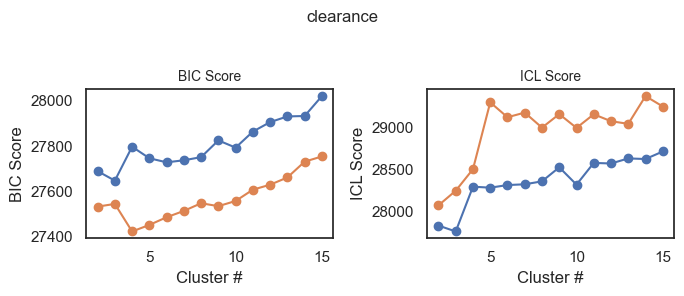

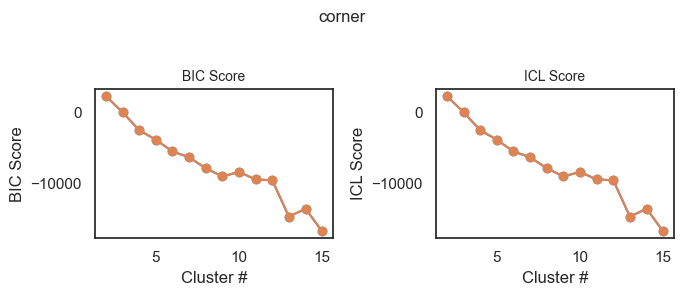

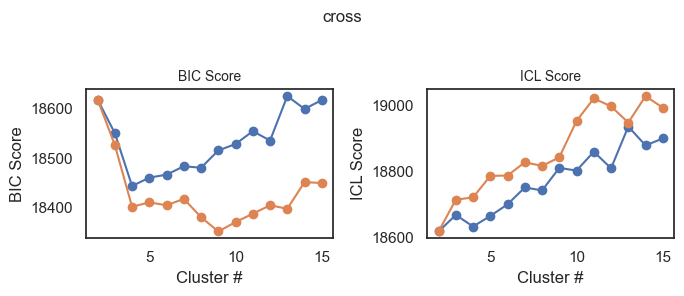

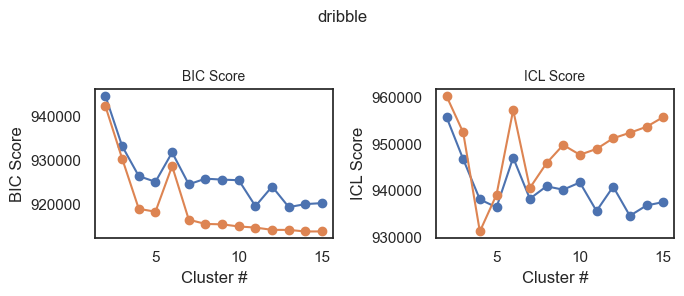

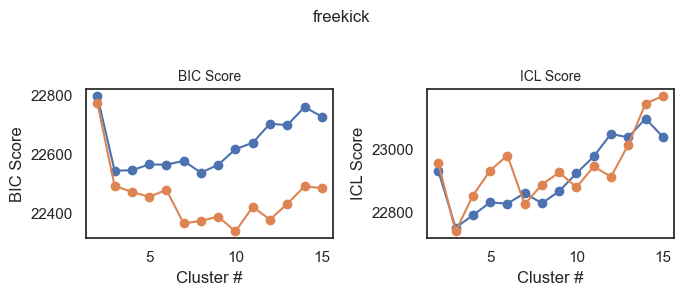

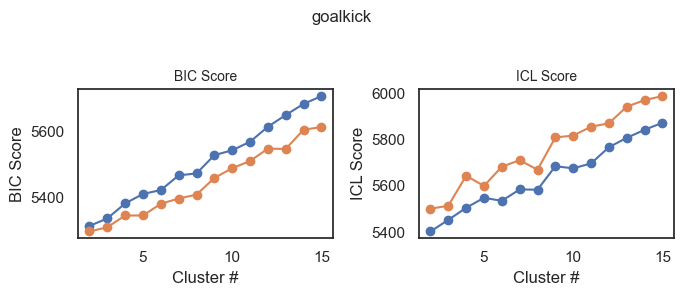

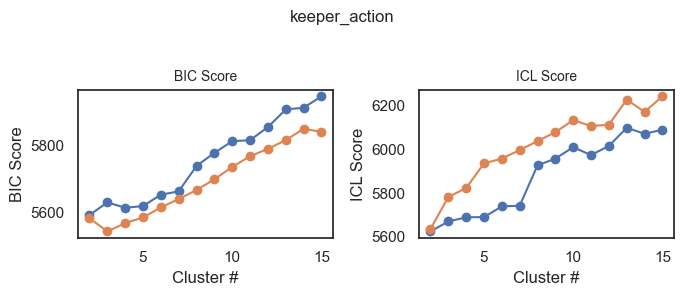

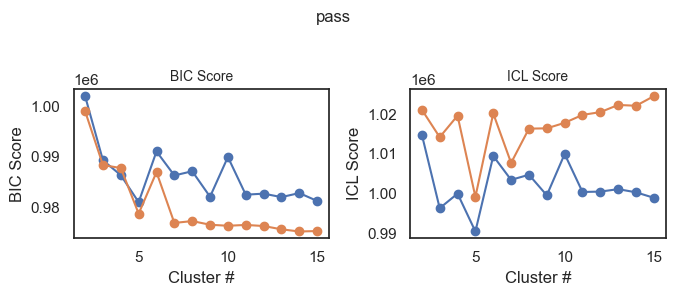

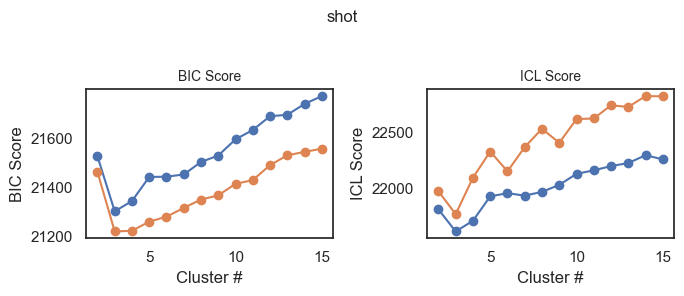

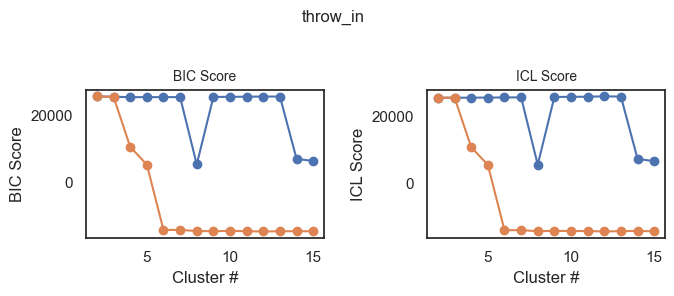

In [7]:
# Loop through each action_type and make a (1,2) plot per type
action_types = action_types
for action_type in action_types:
    fig, axes = plt.subplots(1, 2, figsize=(7, 3))
    fig.suptitle(f"{action_type}", fontsize=12)

    c_step_mask = ((loc_scores["action_type"] == action_type) &
                   (loc_scores["c_step"] == True))
    no_c_step_mask = ((loc_scores["action_type"] == action_type) &
                      (loc_scores["c_step"] == False))

    # BIC Score subplot
    axes[0].plot(loc_scores[c_step_mask]["cluster_nbr"], loc_scores[c_step_mask]["bic"], marker="o")
    axes[0].plot(loc_scores[no_c_step_mask]["cluster_nbr"], loc_scores[no_c_step_mask]["bic"], marker="o")
    axes[0].set_title("BIC Score", fontsize=10)
    axes[0].set_xlabel("Cluster #")
    axes[0].set_ylabel("BIC Score")

    # ICL Score subplot
    axes[1].plot(loc_scores[c_step_mask]["cluster_nbr"], loc_scores[c_step_mask]["completed_bic"], marker="o")
    axes[1].plot(loc_scores[no_c_step_mask]["cluster_nbr"], loc_scores[no_c_step_mask]["completed_bic"], marker="o")
    axes[1].set_title("ICL Score", fontsize=10)
    axes[1].set_xlabel("Cluster #")
    axes[1].set_ylabel("ICL Score")

    plt.tight_layout(rect=(0.0, 0.0, 1.0, 0.95))
    plt.show()

In [8]:
opt_loc_K_EM = {
    f"{action_type}": group.loc[group["bic"].idxmin(), "cluster_nbr"]
    for action_type, group in loc_scores[loc_scores["c_step"] == False].groupby("action_type")
}
opt_loc_K_CEM = {
    f"{action_type}": group.loc[group["completed_bic"].idxmin(), "cluster_nbr"]
    for action_type, group in loc_scores[loc_scores["c_step"] == True].groupby("action_type")
}
print("Standard EM")
print(opt_loc_K_EM)
print("Classification EM")
print(opt_loc_K_CEM)

Standard EM
{'clearance': 4, 'corner': 15, 'cross': 9, 'dribble': 14, 'freekick': 10, 'goalkick': 2, 'keeper_action': 3, 'pass': 14, 'shot': 3, 'throw_in': 12}
Classification EM
{'clearance': 3, 'corner': 15, 'cross': 2, 'dribble': 13, 'freekick': 3, 'goalkick': 2, 'keeper_action': 2, 'pass': 5, 'shot': 3, 'throw_in': 8}


In [9]:
# munually check the optimal clusters
opt_loc_K = {
    'clearance': 4,
    'corner': 2,
    'cross': 4,
    'dribble': 5,
    'freekick': 3,
    'goalkick': 2,
 #   'interception' : 6,
    'keeper_action': 3,
    'pass': 5,
    'shot': 3,
    'throw_in': 6
}


In [10]:
loc_models = {}
for action_type in action_types:
    print(f"Processing {action_type}...")
    for c_step in [False, True]:
        mask = (actions["type_name"] == action_type)
        loc_data = actions[mask][["start_x", "start_y"]]
        loc_K = opt_loc_K[action_type]
        gauss_clusters = [sc.MultivariateGaussian() for _ in range(loc_K)]
        loc_model = sc.MixtureModel(gauss_clusters,
                                    init='k-means')
        _ = loc_model.fit(loc_data,
                          verbose=True,
                          m_step='bregman',
                          c_step=c_step)

        loc_models[f"{action_type}_c={int(c_step)}"] = loc_model


Processing clearance...
Converged at iter 67: LL=-6.66, Delta LL=9.85e-05
Converged at iter 11: LL=-6.75, Delta LL=0.00e+00
Processing corner...
Converged at iter 11: LL=-2.06, Delta LL=0.00e+00
Converged at iter 11: LL=-2.06, Delta LL=0.00e+00
Processing cross...
Converged at iter 19: LL=-7.09, Delta LL=9.58e-05
Converged at iter 11: LL=-7.11, Delta LL=0.00e+00
Processing dribble...
Converged at iter 74: LL=-8.74, Delta LL=8.06e-05
Converged at iter 58: LL=-8.80, Delta LL=-3.58e-05
Processing freekick...
Converged at iter 32: LL=-8.85, Delta LL=9.49e-05
Converged at iter 14: LL=-8.87, Delta LL=2.59e-05
Processing goalkick...
Converged at iter 11: LL=-3.86, Delta LL=2.63e-05
Converged at iter 15: LL=-3.87, Delta LL=-2.52e-05
Processing keeper_action...
Converged at iter 68: LL=-4.65, Delta LL=9.97e-05
Converged at iter 11: LL=-4.73, Delta LL=0.00e+00
Processing pass...
Converged at iter 108: LL=-8.70, Delta LL=8.09e-05
Converged at iter 123: LL=-8.72, Delta LL=9.91e-05
Processing shot.

In [11]:
print(loc_models["throw_in_c=1"])

MixtureModel(n_components=6)
  ├─ (0) w=0.133  MultivariateGaussian(d=2, mean=[25.748  0.718], cov=[[83.892  0.034], [0.034 0.204]])
  ├─ (1) w=0.196  MultivariateGaussian(d=2, mean=[84.809 67.31 ], cov=[[71.769 -0.221], [-0.221  0.175]])
  ├─ (2) w=0.200  MultivariateGaussian(d=2, mean=[84.913  0.639], cov=[[74.207 -0.037], [-0.037  0.153]])
  ├─ (3) w=0.131  MultivariateGaussian(d=2, mean=[23.784 67.347], cov=[[80.424 -0.15 ], [-0.15   0.167]])
  ├─ (4) w=0.175  MultivariateGaussian(d=2, mean=[54.521  0.696], cov=[[57.033  0.249], [0.249 0.184]])
  └─ (5) w=0.164  MultivariateGaussian(d=2, mean=[54.084 67.326], cov=[[70.329  0.153], [0.153 0.166]])


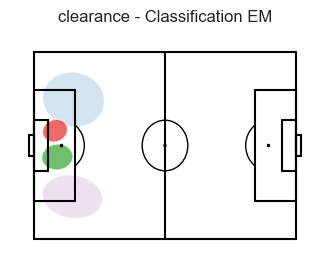

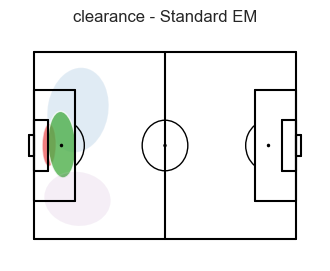

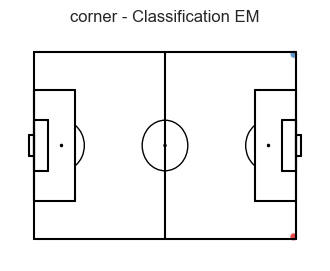

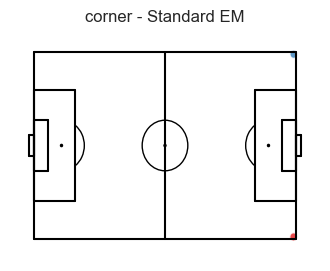

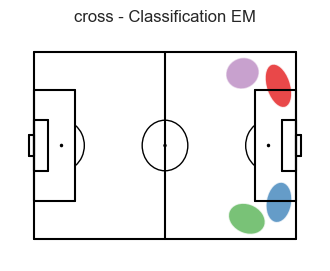

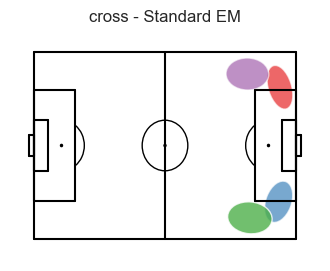

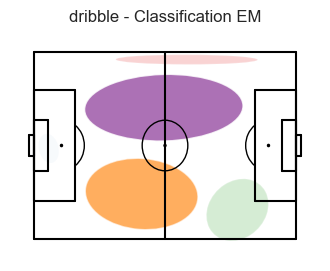

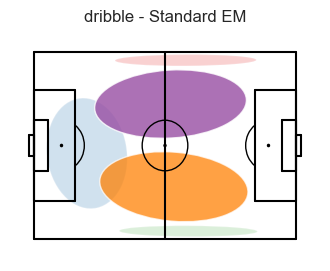

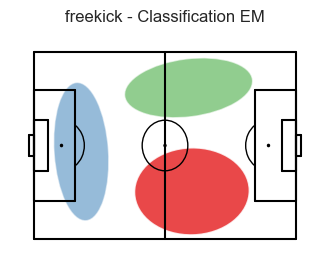

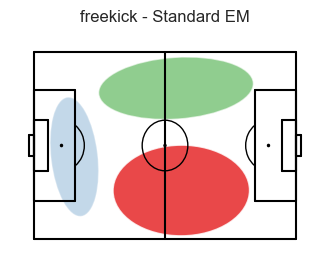

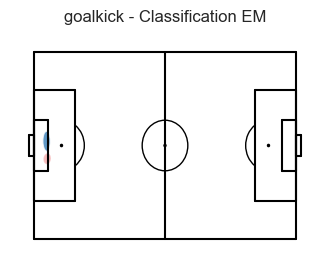

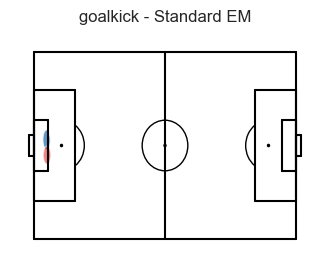

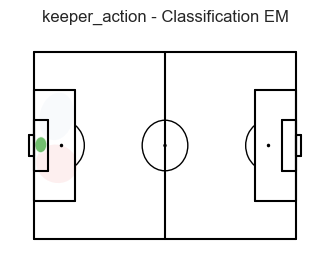

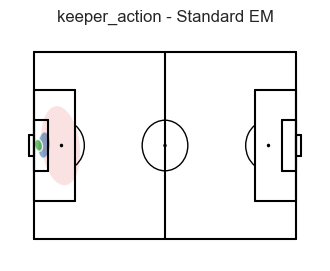

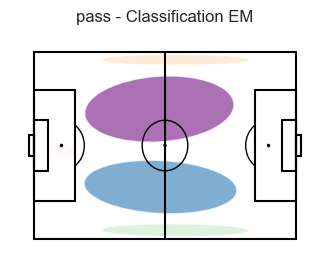

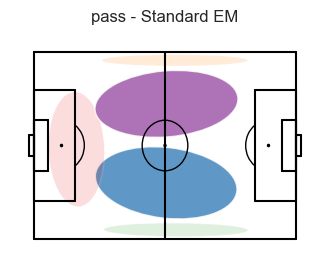

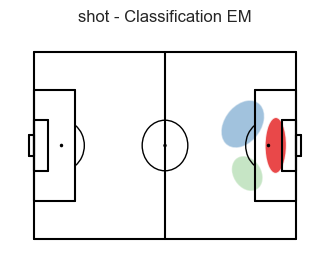

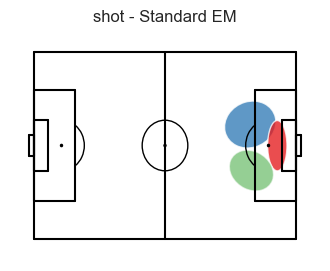

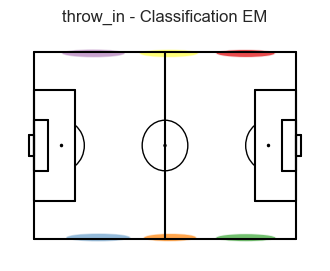

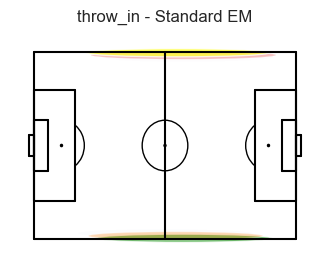

In [12]:
for action_type in action_types:
    vis.show_location_model(loc_models[f"{action_type}_c=1"], figsize=4, title=f"{action_type} - Classification EM")
    vis.show_location_model(loc_models[f"{action_type}_c=0"], figsize=4, title=f"{action_type} - Standard EM")

### Two-Layer Model Experiment

Using the selected number of location clusters, and a fixed amount of direction cluster for each first-layer component.

In [13]:
rows = []
two_layer_models = {}
for action_type in action_types:
    mask = (actions["type_name"] == action_type)
    loc_data = actions[mask][["start_x", "start_y"]].to_numpy()
    dir_data = actions[mask][["cos_angle", "sin_angle"]].to_numpy()
    K_loc = opt_loc_K[action_type]
    K_dir = [3 for _ in range(K_loc)]

    for c_step in [False, True]:
        for m_step in ["bregman", "classic", "approximation"]:
            for init in ["k-means++", "k-means", "random", "random_from_data"]:
                if c_step and init != "k-means": continue

                loc_mixture = sc.MixtureModel(
                    [sc.MultivariateGaussian() for _ in range(K_loc)],
                    init=init
                )
                dir_mixtures = [sc.MixtureModel(
                    [sc.VonMises() for _ in range(K_dir[j])],
                    init=init
                )
                    for j in range(K_loc)]

                model = sc.TwoLayerScheme(loc_mixture,
                                          dir_mixtures)
                start = time()
                it = model.fit(loc_data, dir_data,
                          m_step=m_step,
                          c_step=c_step,
                          tol=1e-2,
                          verbose=False)
                end = time() - start

                two_layer_models[f"{action_type}_c={int(c_step)}_{m_step}_{init}"] = model
                rows.append({
                    "action_type": action_type,
                    "c-step": c_step,
                    "m-step": m_step,
                    "init": init,
                    "bic_score": round(model.bic_score(loc_data, dir_data), 2),
                    "icl_score": round(model.completed_bic_score(loc_data, dir_data),2),
                    "running_time": round(end, 3),
                    "iterations": it,
                })
                print(rows[-1])

two_layer_results = pd.DataFrame(rows)

{'action_type': 'clearance', 'c-step': False, 'm-step': 'bregman', 'init': 'k-means++', 'bic_score': 33613.07, 'icl_score': 35526.7, 'running_time': 0.225, 'iterations': 199}
{'action_type': 'clearance', 'c-step': False, 'm-step': 'bregman', 'init': 'k-means', 'bic_score': 33531.08, 'icl_score': 35399.5, 'running_time': 0.925, 'iterations': 349}
{'action_type': 'clearance', 'c-step': False, 'm-step': 'bregman', 'init': 'random', 'bic_score': 33715.84, 'icl_score': 36689.04, 'running_time': 0.448, 'iterations': 491}
{'action_type': 'clearance', 'c-step': False, 'm-step': 'bregman', 'init': 'random_from_data', 'bic_score': 33610.28, 'icl_score': 35232.61, 'running_time': 0.251, 'iterations': 155}
{'action_type': 'clearance', 'c-step': False, 'm-step': 'classic', 'init': 'k-means++', 'bic_score': 33854.91, 'icl_score': 37823.45, 'running_time': 0.385, 'iterations': 112}
{'action_type': 'clearance', 'c-step': False, 'm-step': 'classic', 'init': 'k-means', 'bic_score': 33530.35, 'icl_score'

In [14]:
two_layer_results

,action_type,c-step,m-step,init,bic_score,icl_score,running_time,iterations
0,clearance,False,bregman,k-means++,33613.07,35526.70,0.225,199
1,clearance,False,bregman,k-means,33531.08,35399.50,0.925,349
2,clearance,False,bregman,random,33715.84,36689.04,0.448,491
3,clearance,False,bregman,random_from_data,33610.28,35232.61,0.251,155
4,clearance,False,classic,k-means++,33854.91,37823.45,0.385,112
...,...,...,...,...,...,...,...,...
145,throw_in,False,approximation,random,49763.32,59714.06,0.255,216
146,throw_in,False,approximation,random_from_data,29934.80,30773.34,0.321,258
147,throw_in,True,bregman,k-means,30425.65,30980.70,0.666,47
148,throw_in,True,classic,k-means,30426.09,30980.78,0.521,47


### One-shot Model Experiment

Using the number of clusters equals 3 times the number of location clusters used before.

In [15]:
rows = []
one_shot_models = {}
for action_type in action_types:
    mask = (actions["type_name"] == action_type)
    loc_data = actions[mask][["start_x", "start_y"]].to_numpy()
    dir_data = actions[mask][["cos_angle", "sin_angle"]].to_numpy()
    K = opt_loc_K[action_type] * 3

    for c_step in [False, True]:
        for m_step in ["bregman", "classic", "approximation"]:
            for init in ["k-means++", "k-means", "random", "random_from_data"]:
                if c_step and init != "k-means": continue

                model = sc.OneShotScheme(n_clusters=K, alpha=1, beta=1, init=init)

                start = time()
                it = model.fit(loc_data, dir_data,
                          m_step=m_step,
                          c_step=c_step,
                          tol=1e-2,
                          verbose=False)
                end = time() - start

                one_shot_models[f"{action_type}_c={int(c_step)}_{m_step}_{init}"] = model
                rows.append({
                    "action_type": action_type,
                    "c-step": c_step,
                    "m-step": m_step,
                    "init": init,
                    "bic_score": round(model.bic_score(loc_data, dir_data), 2),
                    "icl_score": round(model.completed_bic_score(loc_data, dir_data),2),
                    "running_time": round(end, 3),
                    "iterations": it,
                })
                print(rows[-1])

one_shot_results = pd.DataFrame(rows)

{'action_type': 'clearance', 'c-step': False, 'm-step': 'bregman', 'init': 'k-means++', 'bic_score': 33498.46, 'icl_score': 35003.56, 'running_time': 0.113, 'iterations': 11}
{'action_type': 'clearance', 'c-step': False, 'm-step': 'bregman', 'init': 'k-means', 'bic_score': 33552.23, 'icl_score': 35055.16, 'running_time': 0.164, 'iterations': 11}
{'action_type': 'clearance', 'c-step': False, 'm-step': 'bregman', 'init': 'random', 'bic_score': 33590.83, 'icl_score': 37211.59, 'running_time': 0.117, 'iterations': 14}
{'action_type': 'clearance', 'c-step': False, 'm-step': 'bregman', 'init': 'random_from_data', 'bic_score': 33658.04, 'icl_score': 35134.09, 'running_time': 0.247, 'iterations': 11}
{'action_type': 'clearance', 'c-step': False, 'm-step': 'classic', 'init': 'k-means++', 'bic_score': 33507.71, 'icl_score': 35015.92, 'running_time': 0.21, 'iterations': 11}
{'action_type': 'clearance', 'c-step': False, 'm-step': 'classic', 'init': 'k-means', 'bic_score': 33550.74, 'icl_score': 35

In [16]:
one_shot_results

,action_type,c-step,m-step,init,bic_score,icl_score,running_time,iterations
0,clearance,False,bregman,k-means++,33498.46,35003.56,0.113,11
1,clearance,False,bregman,k-means,33552.23,35055.16,0.164,11
2,clearance,False,bregman,random,33590.83,37211.59,0.117,14
3,clearance,False,bregman,random_from_data,33658.04,35134.09,0.247,11
4,clearance,False,classic,k-means++,33507.71,35015.92,0.210,11
...,...,...,...,...,...,...,...,...
145,throw_in,False,approximation,random,-7774.67,-7749.69,0.171,22
146,throw_in,False,approximation,random_from_data,-8323.46,-8136.25,0.371,20
147,throw_in,True,bregman,k-means,13164.23,13446.16,0.372,14
148,throw_in,True,classic,k-means,13163.44,13445.40,0.532,14


### Comparing models

In [17]:
compare = two_layer_results.merge(one_shot_results,
                                  on=["action_type", "c-step", "m-step","init"],
                                  suffixes=("_tl", "_os"))  #os: one-shot, tl: two-layer

cond = [
    (compare["c-step"] == False) & (compare["m-step"] == "bregman") & (compare["init"] == "k-means"),
    (compare["c-step"] == False) & (compare["m-step"] == "bregman") & (compare["init"] == "k-means++"),
    (compare["c-step"] == False) & (compare["m-step"] == "bregman") & (compare["init"] == "random_from_data"),
    (compare["c-step"] == False) & (compare["m-step"] == "bregman") & (compare["init"] == "random"),

    (compare["c-step"] == False) & (compare["m-step"] == "classic") & (compare["init"] == "k-means"),
    (compare["c-step"] == False) & (compare["m-step"] == "classic") & (compare["init"] == "k-means++"),
    (compare["c-step"] == False) & (compare["m-step"] == "classic") & (compare["init"] == "random_from_data"),
    (compare["c-step"] == False) & (compare["m-step"] == "classic") & (compare["init"] == "random"),

    (compare["c-step"] == False) & (compare["m-step"] == "approximation") & (compare["init"] == "k-means"),
    (compare["c-step"] == False) & (compare["m-step"] == "approximation") & (compare["init"] == "k-means++"),
    (compare["c-step"] == False) & (compare["m-step"] == "approximation") & (compare["init"] == "random_from_data"),
    (compare["c-step"] == False) & (compare["m-step"] == "approximation") & (compare["init"] == "random"),

    (compare["c-step"] == True) & (compare["m-step"] == "bregman") & (compare["init"] == "k-means"),
    (compare["c-step"] == True) & (compare["m-step"] == "classic") & (compare["init"] == "k-means"),
    (compare["c-step"] == True) & (compare["m-step"] == "approximation") & (compare["init"] == "k-means"),

]

choice = ["B. k-Means", "B. k-Means++", "B. RandData", "B. Random",
          "C. k-Means", "C. k-Means++", "C. RandData", "C. Random",
          "A. k-Means", "A. k-Means++", "A. RandData", "A. Random",
          "B. CEM", "C. CEM", "A. CEM"]

compare["short_name"] = np.select(cond, choice, default='NA')

compare["bic_diff"] = compare["bic_score_tl"] - compare["bic_score_os"]
compare["icl_diff"] = compare["icl_score_tl"] - compare["icl_score_os"]
compare["runtime_diff"] = compare["running_time_tl"] - compare["running_time_os"]
# Negative diff means two-layer is better

compare

,action_type,c-step,m-step,init,bic_score_tl,icl_score_tl,running_time_tl,iterations_tl,bic_score_os,icl_score_os,running_time_os,iterations_os,short_name,bic_diff,icl_diff,runtime_diff
0,clearance,False,bregman,k-means++,33613.07,35526.70,0.225,199,33498.46,35003.56,0.113,11,B. k-Means++,114.61,523.14,0.112
1,clearance,False,bregman,k-means,33531.08,35399.50,0.925,349,33552.23,35055.16,0.164,11,B. k-Means,-21.15,344.34,0.761
2,clearance,False,bregman,random,33715.84,36689.04,0.448,491,33590.83,37211.59,0.117,14,B. Random,125.01,-522.55,0.331
3,clearance,False,bregman,random_from_data,33610.28,35232.61,0.251,155,33658.04,35134.09,0.247,11,B. RandData,-47.76,98.52,0.004
4,clearance,False,classic,k-means++,33854.91,37823.45,0.385,112,33507.71,35015.92,0.210,11,C. k-Means++,347.20,2807.53,0.175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,throw_in,False,approximation,random,49763.32,59714.06,0.255,216,-7774.67,-7749.69,0.171,22,A. Random,57537.99,67463.75,0.084
146,throw_in,False,approximation,random_from_data,29934.80,30773.34,0.321,258,-8323.46,-8136.25,0.371,20,A. RandData,38258.26,38909.59,-0.050
147,throw_in,True,bregman,k-means,30425.65,30980.70,0.666,47,13164.23,13446.16,0.372,14,B. CEM,17261.42,17534.54,0.294
148,throw_in,True,classic,k-means,30426.09,30980.78,0.521,47,13163.44,13445.40,0.532,14,C. CEM,17262.65,17535.38,-0.011


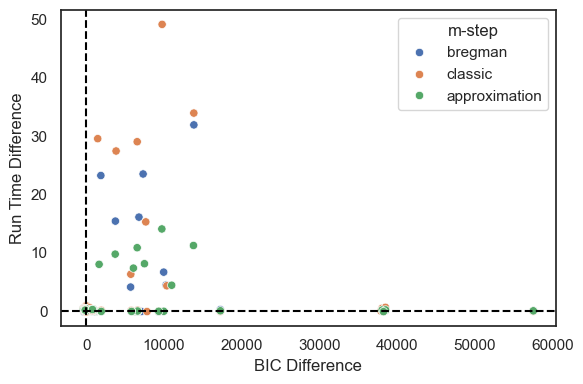

In [18]:
plt.figure(figsize=(6, 4))
sns.scatterplot(data=compare, x="bic_diff", y="runtime_diff", hue="m-step")
plt.axvline(0.1, color='black', linestyle='--')
plt.axhline(0.1, color='black', linestyle='--')

plt.xlabel("BIC Difference")
plt.ylabel("Run Time Difference")

plt.tight_layout()
plt.savefig("plots/models_performance_comparison_bic.pdf")
plt.show()

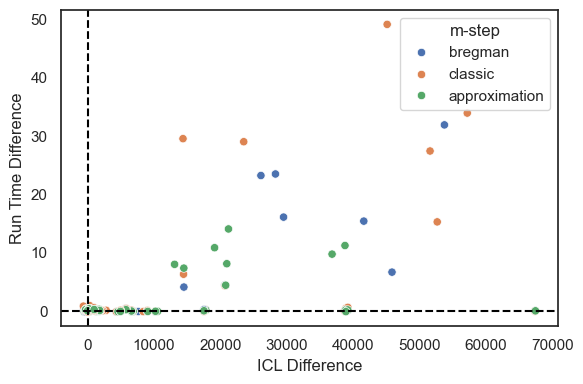

In [19]:
plt.figure(figsize=(6, 4))
sns.scatterplot(data=compare, x="icl_diff", y="runtime_diff", hue="m-step")
plt.axvline(0.1, color='black', linestyle='--')
plt.axhline(0.1, color='black', linestyle='--')
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel("ICL Difference")
plt.ylabel("Run Time Difference")

plt.tight_layout()
plt.savefig("plots/models_performance_comparison_icl.pdf")
plt.show()

In [26]:
# Two Layer Model Plots
for name, model in two_layer_models.items():
    model.plot(figsize=4, name=f"tl_{name}", show_title=False, save=True, show=False)

In [27]:
# One Shot Model Plots
for name, model in one_shot_models.items():
    model.plot(figsize=4, name=f"os_{name}", show_title=False, save=True, show=False)

In [28]:
def plot_performance(df, value='bic_score', save=False, ylabel=None):
    for action_type in df["action_type"].unique():
        print(action_type)
        # Filter and set index
        df_filtered = df[df["action_type"] == action_type]
        #df_filtered = df_filtered.set_index("short_name").sort_index()
        names = df_filtered['short_name']
        x = np.arange(len(names))
        width = 0.35

        fig, ax = plt.subplots(figsize=(6, 4))
        ax.bar(x - width / 2, df_filtered[f'{value}_tl'], width,
               label='Two-Layer')
        ax.bar(x + width / 2, df_filtered[f'{value}_os'], width, label='One-shot')

        min_val = df_filtered[[f'{value}_tl', f'{value}_os']].min().min()
        max_val = df_filtered[[f'{value}_tl', f'{value}_os']].max().max()
        ax.set_ylim(0.95 * min_val if min_val > 0 else 1.05 * min_val,
                    1.05 * max_val if max_val > 0 else 0.95 * max_val)

        ax.set_xticks(x)
        ax.set_xticklabels(names, rotation=60)
        if ylabel:
            ax.set_ylabel(ylabel)
        ax.legend(loc="upper right")
        plt.tight_layout()
        if save:
            plt.savefig(f"plots/perf_{value}_{action_type}.pdf")
        plt.show()

clearance


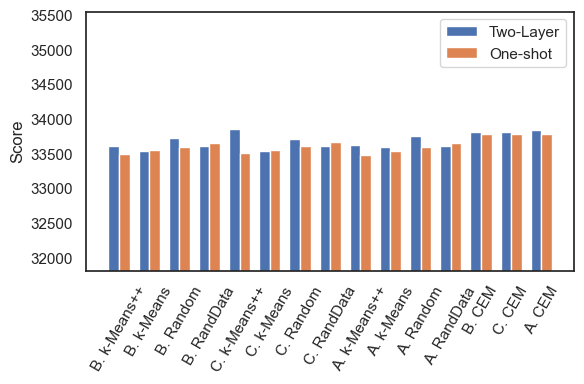

corner


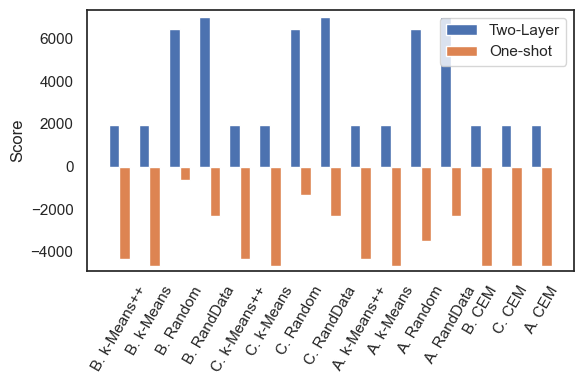

cross


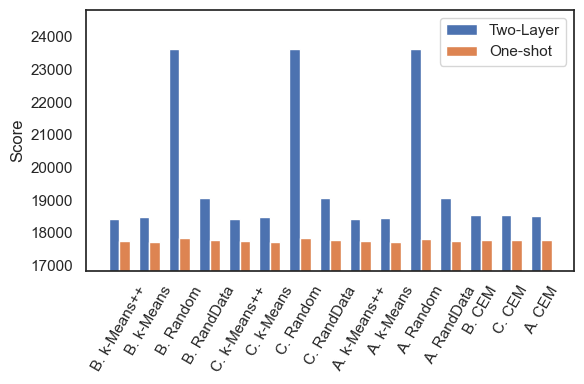

dribble


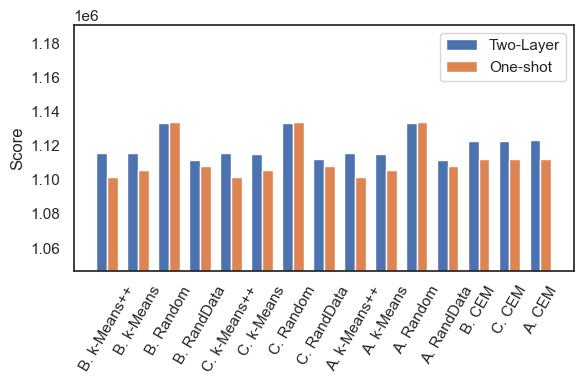

freekick


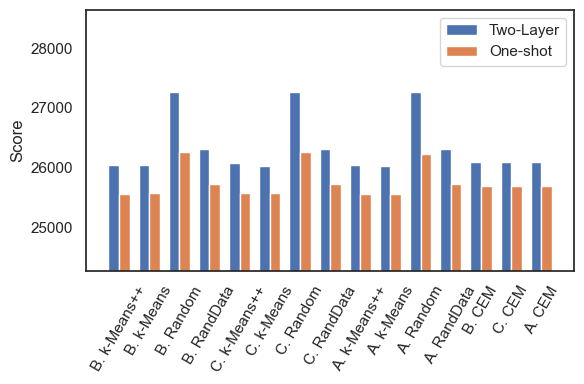

goalkick


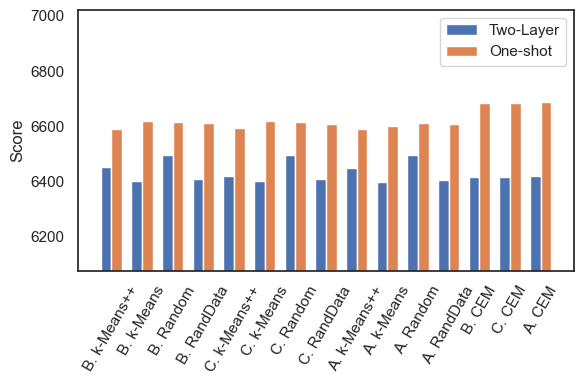

keeper_action


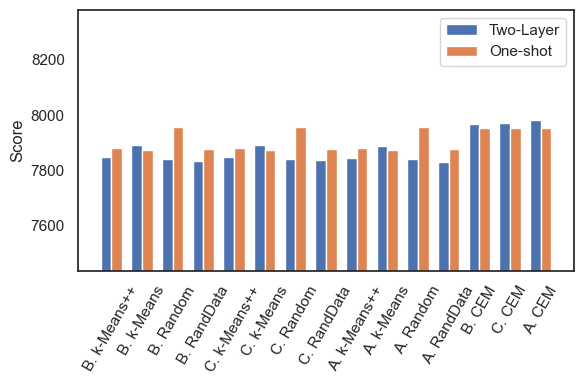

pass


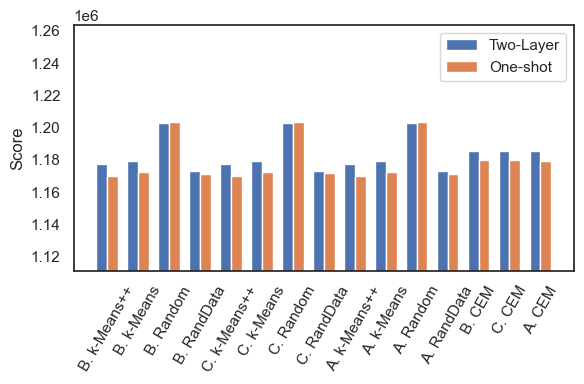

shot


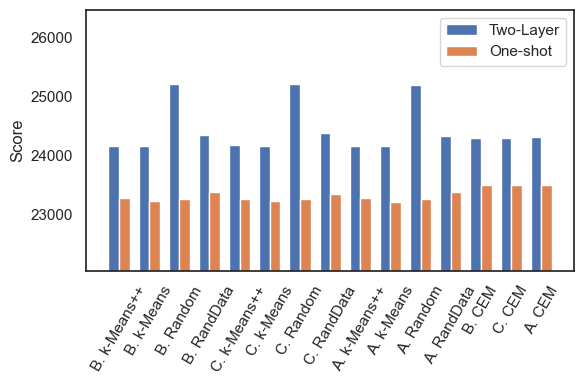

throw_in


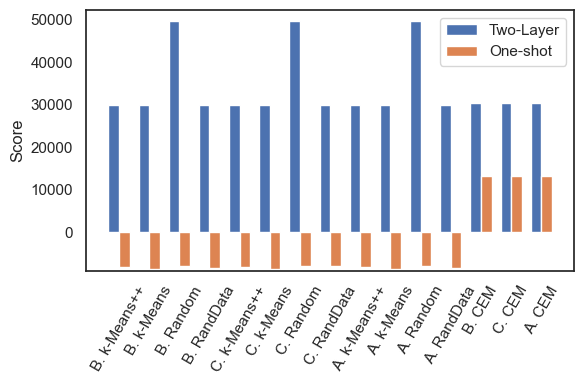

In [29]:
plot_performance(compare, 'bic_score', True, 'Score')

clearance


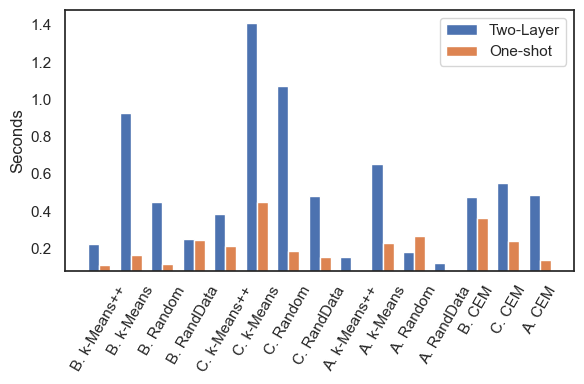

corner


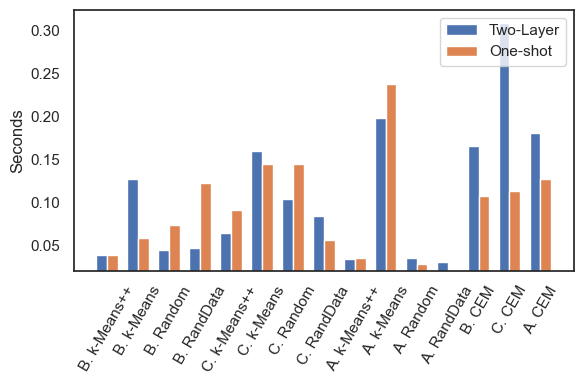

cross


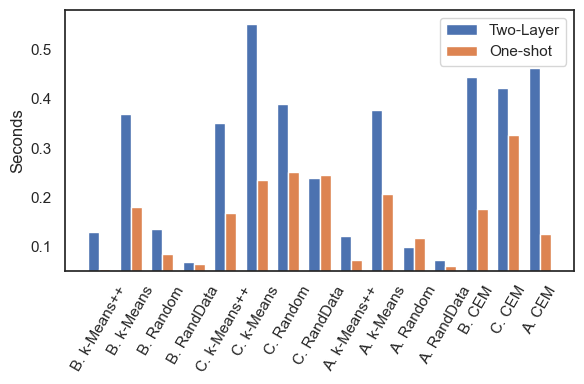

dribble


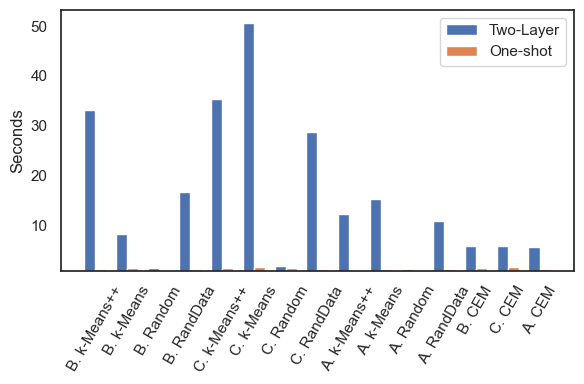

freekick


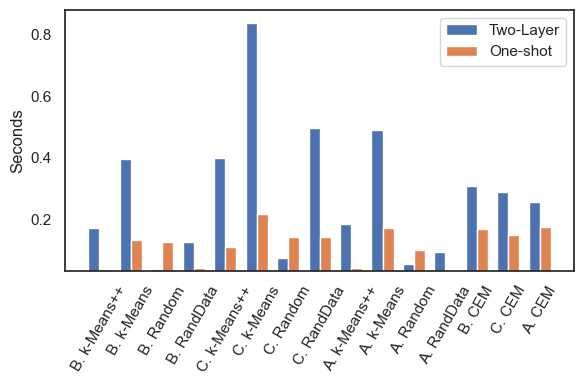

goalkick


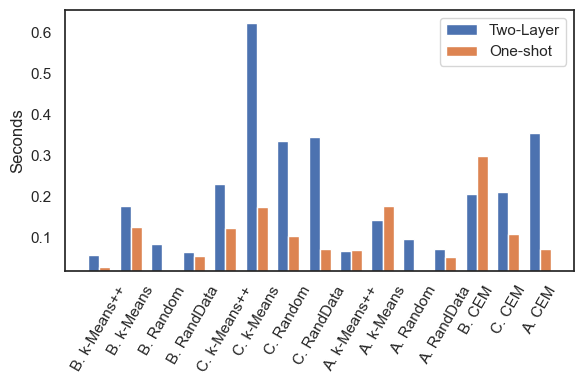

keeper_action


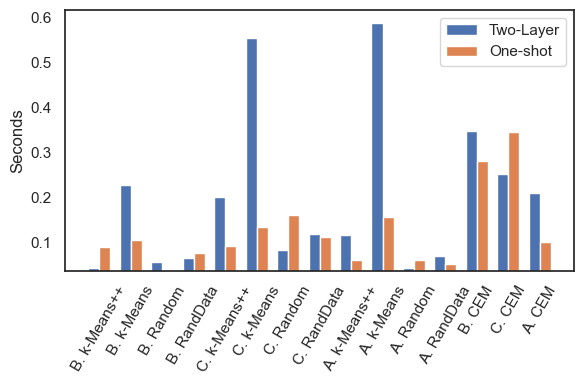

pass


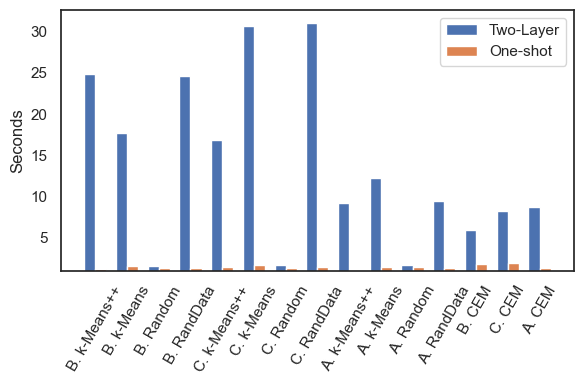

shot


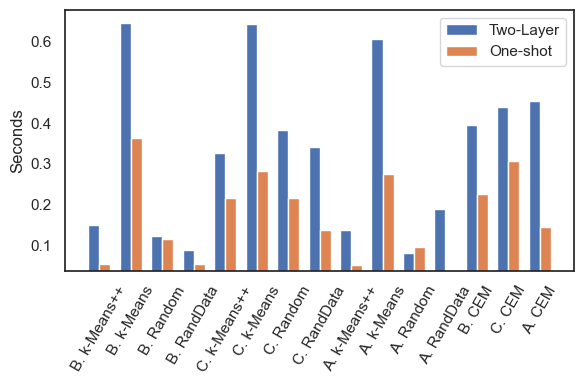

throw_in


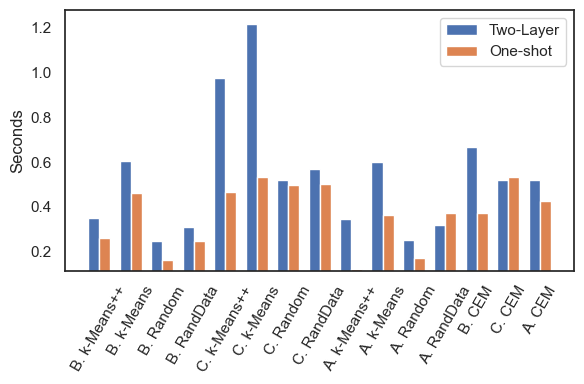

In [30]:
plot_performance(compare, 'running_time', True, 'Seconds')

clearance


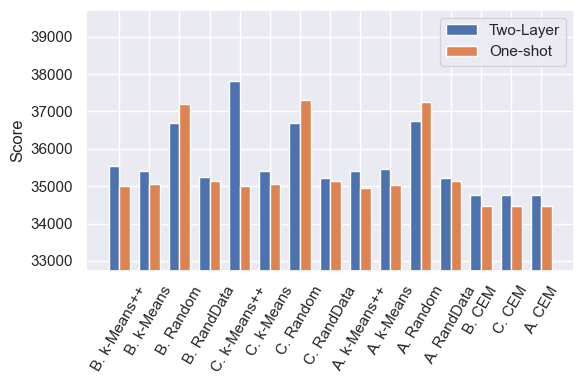

corner


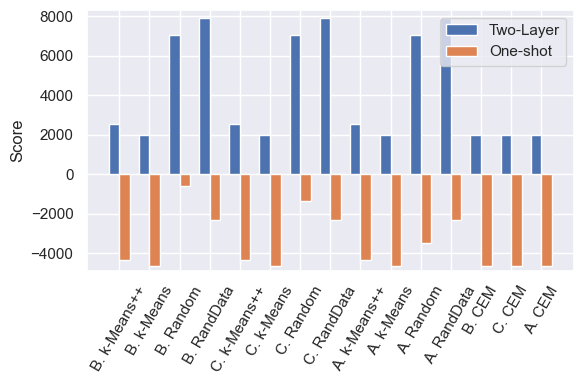

cross


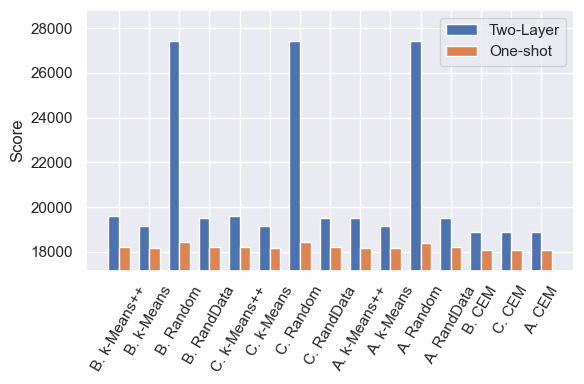

dribble


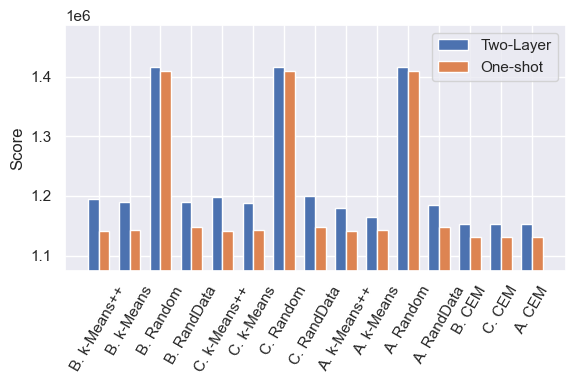

freekick


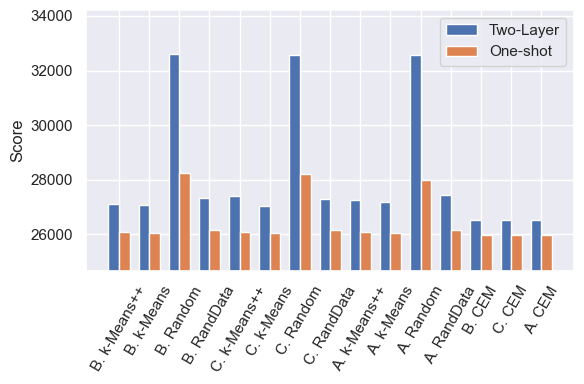

goalkick


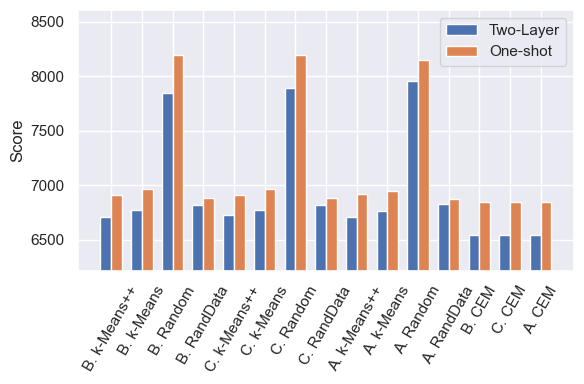

keeper_action


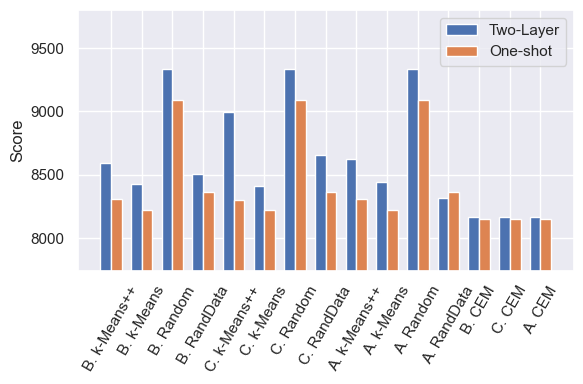

pass


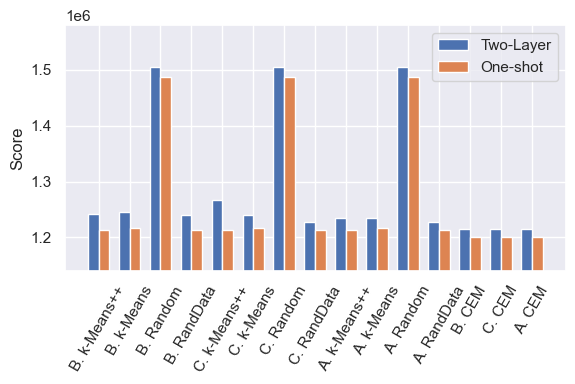

shot


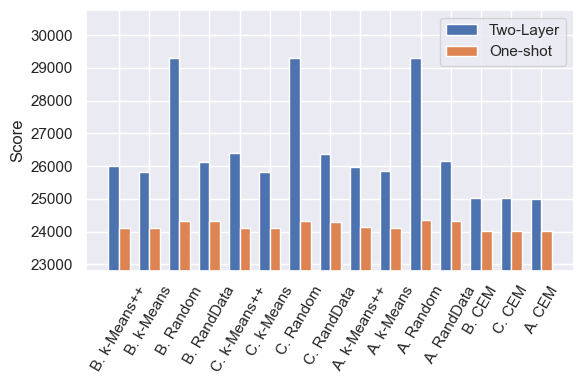

throw_in


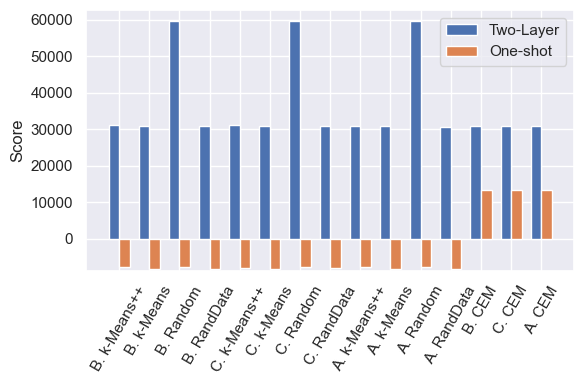

In [31]:
plot_performance(compare, 'icl_score', True, 'Score')